# Part 0B (prequel) Shuffled MMLU benchmark analysis  

Please skip to Part 1 notebook to see interesting clean stuff.  
This notebook is only here for its archeological interest. 

In the previous notebook, we found a weird label distribution, where A choices accounted for 70% of all answers.  
This time, we will shuffle choices and vote for the most frequent answer.  

We will also test an easier category to check whether the bias in letter chosen is justified or not.  

## install libs

In [21]:
# !pip install matplotlib #if needed
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [1]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()

!pip install transformers datasets
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -U --no-deps xformers==0.0.25.post1 trl peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-usa8n0qu/unsloth_d2a931f5d8a949c8aa796ee95a5bf254
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-usa8n0qu/unsloth_d2a931f5d8a949c8aa796ee95a5bf254
  Resolved https://github.com/unslothai/unsloth.git to commit 27fa021a7bb959a53667dd4e7cdb9598c207aa0d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# !pip install -U xformers==0.0.25.post1

## load dataset

In [3]:
from datasets import load_dataset

# Load the MMLU dataset
dataset = load_dataset("tasksource/mmlu", 'abstract_algebra', split='test')

In [4]:
dataset

Dataset({
    features: ['question', 'choices', 'answer'],
    num_rows: 100
})

## load model

In [5]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.999 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def format_choice(example_choices):

  letters = ["A", "B", "C", "D"]

  lines = []
  for letter, choice in zip(letters, example_choices):
    lines.append(f"  {letter}) {choice}  ")

  return "\n".join(lines) + '\n'

### random choice order inference  

We have to:  
1. shuffle the choices  
2. adapt the tokens to match the new choice order  
3. decode the result to match the static dataset (no matter the choice order, if answer 0 is the correct answer, then we must always return 0)  

#### generate letter orders

In [7]:
from itertools import permutations
import random

# Generate all possible 4-letter words with the letters ABCD
letters = ['A', 'B', 'C', 'D']
all_words = [''.join(word) for word in permutations(letters, 4)]

# Function to select N unique elements at random from the list
def select_random_elements(N):
    return random.sample(all_words, N)

# Example usage
N = 5  # Change N to the desired number of elements
selected_words = select_random_elements(N)

In [8]:
selected_words

['BACD', 'BCDA', 'BCAD', 'DBAC', 'BDCA']

#### reorder choices based on new letter order

In [9]:
def convert_letter_to_index(letter):
  letter_to_index_dict = {
      'A' : 0,
      'B' : 1,
      'C' : 2,
      'D' : 3
  }
  return letter_to_index_dict[letter]

def reorder_choices_based_on_letter_order(choices, letter_order):
  new_choices = []
  for letter in letter_order:
    new_choices.append(choices[convert_letter_to_index(letter)])

  return new_choices

#### make a new token string based on new letter order

In [10]:
def generate_answer_token_string(letter_order):
  return f" {letter_order[0]} {letter_order[1]} {letter_order[2]} {letter_order[3]}"

In [11]:
generate_answer_token_string(selected_words[0])

' B A C D'

#### translate result based on letter order  

We have to map the result from the shuffled choice to the static result from the dataset.

In [12]:
def translate_answer_based_on_letter_order(answer, letter_order):
  default_letter_order = list('ABCD')
  curr_letter_order = list(letter_order)
  conversion_dict = dict(zip(default_letter_order, curr_letter_order))
  return conversion_dict[answer]

translate_answer_based_on_letter_order("A", "DCBA")

'D'

In [13]:
def most_common(lst):
    return max(set(lst), key=lst.count)


## Apply to the dataset

In [14]:
dataset_df = dataset.to_pandas()
dataset_df.head()

,question,choices,answer
0,Find the degree for the given field extension ...,"[0, 4, 2, 6]",1
1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...","[8, 2, 24, 120]",2
2,Find all zeros in the indicated finite field o...,"[0, 1, 0,1, 0,4]",3
3,Statement 1 | A factor group of a non-Abelian ...,"[True, True, False, False, True, False, False,...",1
4,Find the product of the given polynomials in t...,"[2x^2 + 5, 6x^2 + 4x + 6, 0, x^2 + 1]",1


## Change dataset - Take an easier one

Until now, we have used the `abstract_algebra` test dataset.  
We will now use an easier one: `high_school_biology` (seems easier to me)  

In [15]:
dataset_simple = load_dataset("tasksource/mmlu", 'high_school_biology', split='test')

We select the first 100 questions to speed up the benchmark:

In [16]:
dataset_simple_df = dataset_simple.to_pandas()
dataset_simple_df = dataset_simple_df.head(100)
dataset_simple_df.head()

,question,choices,answer
0,"In a population of giraffes, an environmental ...","[directional selection., stabilizing selection...",0
1,Which of the changes below following the start...,"[a deletion of a single nucleotide, a deletion...",0
2,The energy given up by electrons as they move ...,"[break down glucose, make glucose, produce ATP...",2
3,During the period when life is believed to hav...,"[oxygen, hydrogen, ammonia, methane]",0
4,Convergent evolution is best exemplified by wh...,[The pectoral fins of fish and the front legs ...,2


## Batch inference (speeeed)

Batched inference is much faster, and we can compute all choices in parallel.  
Before applying the complete benchmark, we can use this boost.  

In [17]:
from itertools import permutations
import random

mmlu_prompt = """
Answer the following multiple choice question.
The last line of your response should be of the following format: 'The answer letter is : $LETTER' (without quotes) where LETTER is one of A B C D.
Think step by step before answering.

### Question:
{}

### Choices:
{}

### Anwser:
Given the choices A B C D , the answer is : {}"""

def get_number_result_from_question_parallel(question, choices, n_infer=24):

    # Generate all possible 4-letter words with the letters ABCD
    # these are our letter orders to reorder the choices
    letters = ['A', 'B', 'C', 'D']
    letter_orders = [''.join(word) for word in permutations(letters, 4)]

    # case of n_infer being a sample of all possible cases
    if not (n_infer == 24):
      letter_orders = random.sample(letter_orders, n_infer)

    # duplicate questions and choices for each letter order
    questions = [question] * len(letter_orders)
    choices_list = [choices] * len(letter_orders)

    prompts = []
    answer_tokens_list = []
    for question, choices, letter_order in zip(questions, choices_list, letter_orders):
        prompt = mmlu_prompt.format(
            question,
            format_choice(reorder_choices_based_on_letter_order(choices, letter_order)),
            ""  # output - leave blank for model answer
        )
        prompts.append(prompt)

        answer_tokens = tokenizer.encode(
            generate_answer_token_string(letter_order), add_special_tokens=False, return_tensors="pt"
        ).to("cuda")
        answer_tokens_list.append(answer_tokens)

    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to("cuda")

    logits_list = []
    with torch.no_grad():
        logits = model(inputs.input_ids, attention_mask=inputs.attention_mask).logits
        torch.cuda.empty_cache()
        for i, answer_tokens in enumerate(answer_tokens_list):
            logits_ans = logits[i, -1, answer_tokens].cpu()
            logits_list.append(logits_ans)

    results = []
    local_answers = []
    for logits_ans, letter_order in zip(logits_list, letter_orders):
        prob_ans = torch.softmax(logits_ans, dim=-1)
        inferred_answer = prob_ans.argmax(dim=-1)
        local_answers.append(letter_order[inferred_answer])
        result = translate_answer_based_on_letter_order(letter_order[inferred_answer], letter_order)
        result = convert_letter_to_index(result)
        results.append(result)

    # for letter_order, prompt, local_answer in zip(letter_orders, prompts, local_answers):
    #   print('====================================================')
    #   print(letter_order)
    #   print(prompt)
    #   print(f'local answer : {local_answer}')
    #   print(f'translated answer : {translate_answer_based_on_letter_order(local_answer, letter_order)}')
    #   print('====================================================')
    return most_common(results)

# # Example usage
test_question = "What is the capital of France?"

test_choices = ["Monaco", "Barcelona", "Moscow", "Paris"]

get_number_result_from_question_parallel(test_question, test_choices)

3

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

def perform_benchmark_analysis_parallel(input_dataset_df, n_infer=24):

  input_dataset_df['inferred_result'] = input_dataset_df.progress_apply(lambda row: get_number_result_from_question_parallel(row['question'], row['choices'], n_infer), axis=1)
  input_dataset_df['is_correct'] = input_dataset_df['inferred_result'] == input_dataset_df['answer']

  # Display results
  # Transforming data for seaborn countplot
  df_melted = input_dataset_df.melt(value_vars=['inferred_result', 'answer'],
                                    var_name='Metric', value_name='Value')

  df_melted['Metric'] = df_melted['Metric'].str.replace('answer', 'expected_answer')
  df_melted['Metric'] = df_melted['Metric'].str.replace('inferred_result', 'inferred_answer')

  # Plotting
  plt.figure(figsize=(10, 8))
  sns.countplot(data=df_melted, x='Value', hue='Metric')
  plt.title('Frequency Distribution of inferred answer vs expected answer')
  plt.xlabel('Numeric answer class')
  plt.ylabel('Count')
  plt.legend(title='Answer type')
  plt.show()

  # Print mean accuracy
  print(f"Mean accuracy : {input_dataset_df.is_correct.mean()*100:.02f}%")
  print(f"Good answers : {input_dataset_df.is_correct.value_counts().loc[True]}")
  print(f"Bad answers : {input_dataset_df.is_correct.value_counts().loc[False]}")
  return input_dataset_df

  0%|          | 0/100 [00:00<?, ?it/s]

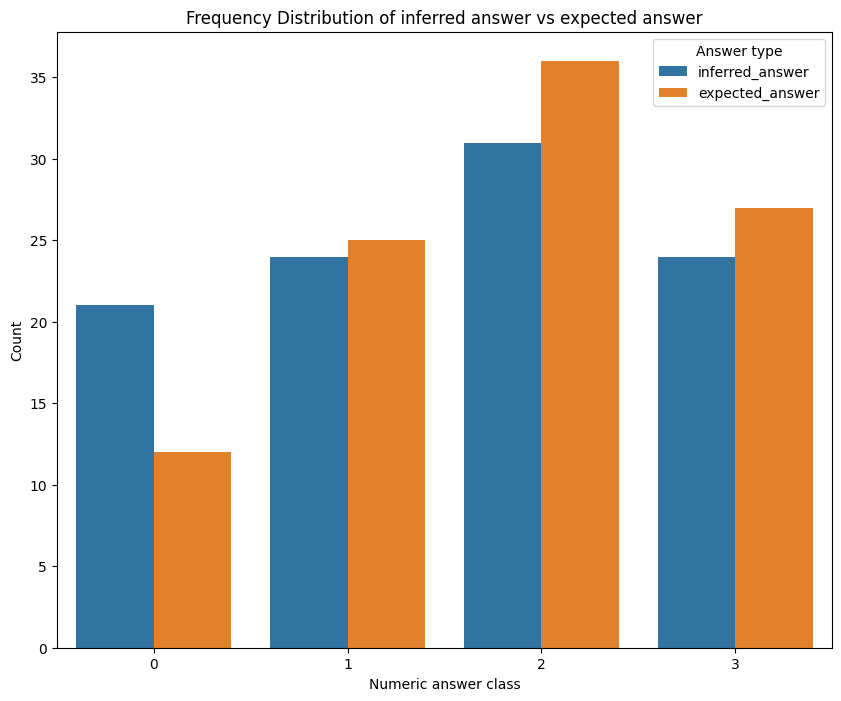

Mean accuracy : 60.00%
Good answers : 60
Bad answers : 40


  0%|          | 0/100 [00:00<?, ?it/s]

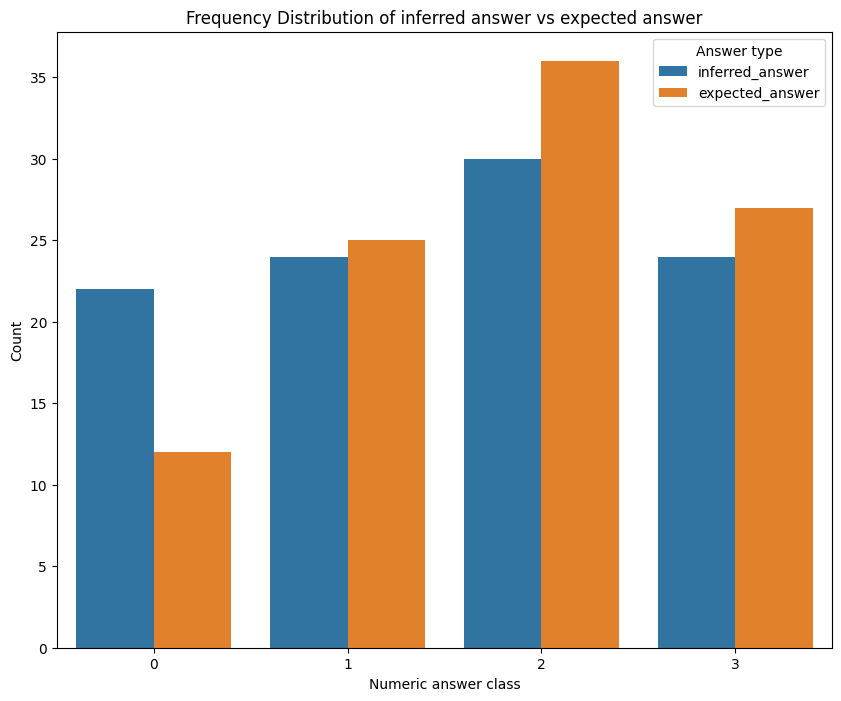

Mean accuracy : 70.00%
Good answers : 70
Bad answers : 30


  0%|          | 0/100 [00:00<?, ?it/s]

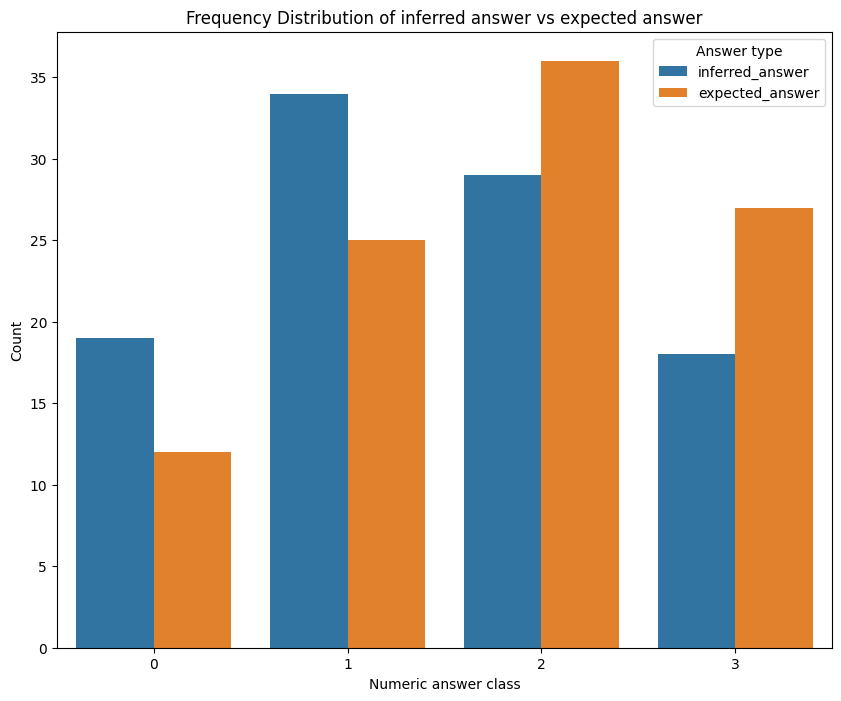

Mean accuracy : 68.00%
Good answers : 68
Bad answers : 32


  0%|          | 0/100 [00:00<?, ?it/s]

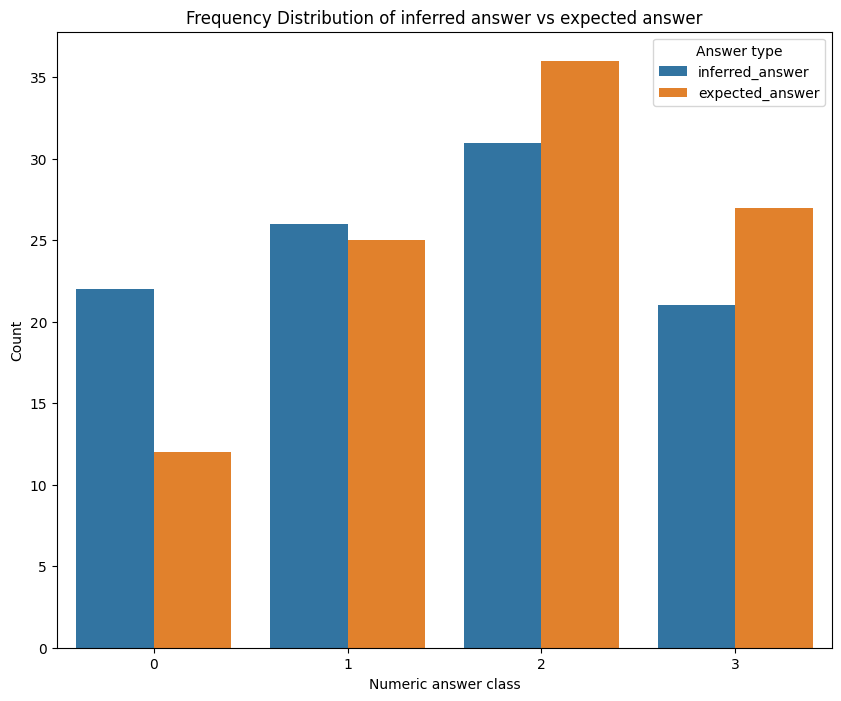

Mean accuracy : 69.00%
Good answers : 69
Bad answers : 31


  0%|          | 0/100 [00:00<?, ?it/s]

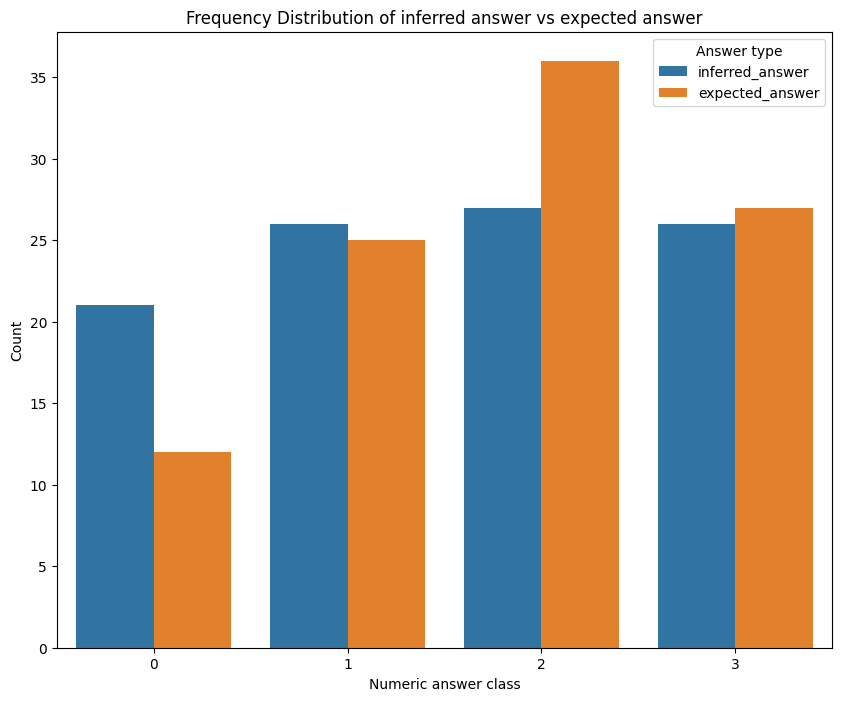

Mean accuracy : 71.00%
Good answers : 71
Bad answers : 29


In [23]:
results_df_list = []

for inference_count in [1, 3, 5, 10, 24]:
  result_df = perform_benchmark_analysis_parallel(dataset_simple_df, inference_count)
  result_df['inference_count'] = inference_count
  results_df_list.append(result_df)

## Conclusion  

We observe marginal gains when we switch from 10 to 24 inference steps. For the complete dataset processing, we will only perform 10 steps.  

With our new batched inference, random choice, and plots, we are ready to tackle the complete MMLU dataset.  

Follow up notebook:  